# Proyecto: Clasificación de Sentimiento en Reseñas de IMDb (Film Junky Union)

**Objetivo**
Film Junky Union quiere un sistema automático para **detectar reseñas negativas** de películas. Usaremos reseñas de IMDb ya etiquetadas para entrenar y comparar varios modelos que clasifiquen cada reseña como **positiva (1)** o **negativa (0)**. El requisito del proyecto es lograr **F1 ≥ 0.85** en el conjunto de prueba.

**Datos**
El archivo `imdb_reviews.tsv` incluye:

* `review`: texto de la reseña (feature principal)
* `pos`: objetivo (`0` = negativo, `1` = positivo)
* `ds_part`: partición ya definida (`train` / `test`)
* metadatos extra (títulos, año, géneros, ratings, votos, etc.) que usaremos **solo para EDA** (no para entrenar el modelo principal, para evitar fuga de información)

**Enfoque**

1. Cargar e inspeccionar los datos y validar que todo sea consistente.
2. Hacer EDA, especialmente el desbalance de clases y la longitud del texto.
3. Construir un modelo base simple (DummyClassifier) para tener un punto de referencia.
4. Construir baselines fuertes con **TF-IDF + Regresión Logística** y un modelo de **boosting** bien ajustado.
5. Afinar **BERT** usando GPU como benchmark moderno.
6. Evaluar en test y analizar diferencias con reseñas escritas manualmente.

**Métrica**
Principal: **F1-score** (accuracy como secundaria).
Usamos F1 porque equilibra precisión y recall, y es más robusta que accuracy si hay desbalance.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from typing import List, Tuple, Dict
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW 
from torch.utils.data import Dataset, DataLoader

# Global settings and constants
RANDOM_SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 256     
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')



In [2]:
# Import data and initial inspection
data = pd.read_csv(r'../data/imdb_reviews.tsv', sep='\t')
display(data.info(), data.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

None

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
27487,tt0045062,short,Rabbit Seasoning,Rabbit Seasoning,1952,\N,7,0,"Animation,Comedy,Family",8.3,3882.0,...And there were quite a few of these. I do n...,7,pos,1,test,2595
8979,tt0451109,movie,Dark Harvest II: The Maize,The Maize: The Movie,2004,\N,100,0,Horror,1.9,2577.0,Besides the comments on the technical merits o...,1,neg,0,test,4195
7214,tt0435617,video,Chupacabra Terror,Chupacabra Terror,2005,\N,88,0,Horror,3.5,1313.0,In case you're wondering the buffoonish Loren ...,1,neg,0,test,11117
12561,tt0444628,movie,Fay Grim,Fay Grim,2006,\N,118,0,"Action,Comedy,Thriller",6.2,4047.0,It seems Hal Hartley's films are kind of hit o...,9,pos,1,train,6191
15910,tt0422401,movie,Hatchet,Hatchet,2006,\N,85,0,"Comedy,Horror,Thriller",5.7,28134.0,another eli roth in the making. self promoting...,1,neg,0,test,3808


In [3]:
# Check NaN values on crucial columns
display(data[['review', 'pos', 'ds_part']].isna().sum())

# Check ds_part column unique values
display(data['ds_part'].value_counts())

# Check pos column unique values
display(data['pos'].value_counts())

# Check duplicates on review column
display(data['review'].duplicated().sum())
# Drop duplicates if any
data = data.drop_duplicates(subset=['review']).reset_index(drop=True)

review     0
pos        0
ds_part    0
dtype: int64

ds_part
train    23796
test     23535
Name: count, dtype: int64

pos
0    23715
1    23616
Name: count, dtype: int64

np.int64(91)

## Observaciones iniciales de la integridad de los datos
* No hay valores NaN en las columnas cruciales (`review`, `pos`, `ds_part`).
* La columna `ds_part` tiene solo los valores esperados (`train`, `test`).
* La columna `pos` tiene solo los valores esperados (`0`, `1`) y está balanceada (~50% cada clase).
* Había algunos duplicados en las reseñas, pero se eliminaron sin afectar el balance de clases.

# **Análisis Exploratorio de Datos (EDA)**

In [4]:
# Split data into train and test sets by the ds_part column
df_train = data.query("ds_part == 'train'").reset_index(drop=True)
df_test = data.query("ds_part == 'test'").reset_index(drop=True)

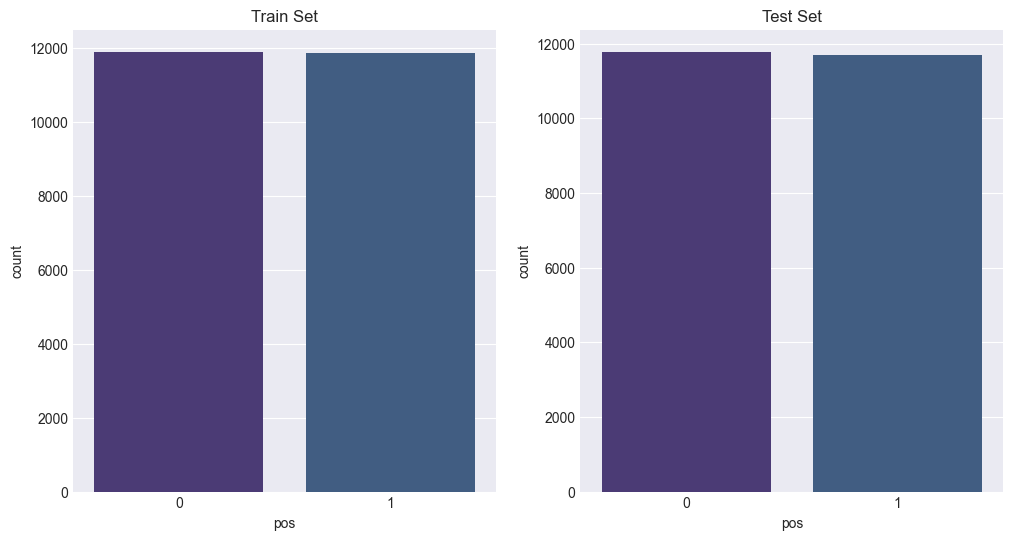

In [5]:
# Distribution of classes in both sets
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x='pos', data=df_train, ax=axes[0], hue='pos', legend=False)
sns.countplot(x='pos', data=df_test, ax=axes[1], hue='pos', legend=False)
axes[0].set_title('Train Set')
axes[1].set_title('Test Set')
plt.show()

In [6]:
# Check quality of reviews' text 
# Positive reviews samples
pos_samples = df_train[df_train['pos'] == 1]['review'].sample(3).values
for i, sample in enumerate(pos_samples, 1):
    print(f"Positive Review Sample {i}:\n{sample}\n")

Positive Review Sample 1:
I did not read anything about the film before I watched it, by chance, last Saturday evening. And then, as I was watching it, I felt the misery of Lena and Boesman into my bones. I was so captivated by the acting and the tone and the filming that I listened only partially to the dialogues. My husband fell asleep soon after we went to bed and I was sleepless, under the impact of the film. I wanted to wake him up just to say:"if I would ever vote for an Oscar nomination, it would be for these two actors." I decided to wait until the next day. Then I read more about the film on IMDb, and was sad to learn that Mr. Berry died before the release of the film and that he had probably never seen the last version of his brilliant masterpiece. I still want to tell him that to me his film was a true independent film, in its concept and spirit. The actors are to be praised not only for their brilliant performance but for accepting a part with no shine, no showing off, well

In [7]:
# Negative reviews samples
neg_samples = df_train[df_train['pos'] == 0]['review'].sample(3).values
for i, sample in enumerate(neg_samples, 1):
    print(f"Negative Review Sample {i}:\n{sample}\n")

Negative Review Sample 1:
A bunch of women who can't act sit around, talk, smoke pot. They have another woman in a wheelchair they hide because she is deformed, and occasionally they kill some one to feed this person human flesh that really looks like some store-bought ham which they dressed up by sticking on a few plastic fingers. We don't see them killing anyone, suddenly there is a body on the floor, covered by a bloodied sheet. I can't eat Spam cover by a sheet anymore because of this. Just the thought of Spam cover by a sheet is enough to induce the same narcoleptic fit brought on by trying to get through all of this movie. Occasionally there are randomly inserted scenes of a guy who is "hunting" them by way of torturing some guy he strapped to a chair is his basement. Why he caught this guy and how he is connected to the Sit-On-The-Couch Sisters is never explained. There are also scenes of some "superhuman" guy freaking out. He p***es blood and punches through a wall, but who he 

In [8]:
# Create length features to help us determinate important parameters in the future
df_train['n_chars'] = df_train['review'].apply(len)
df_train['n_words'] = df_train['review'].apply(lambda x: len(x.split()))
df_train[['review','pos', 'n_chars', 'n_words']].sample(5)

,review,pos,n_chars,n_words
6982,"This is a excellent series. You will laugh, yo...",1,804,146
15299,I just got through watching this DVD at home. ...,0,937,181
14119,I'm all for the idea of a grand epic of the Am...,0,2234,381
17730,One of the finest films ever made! Why it only...,1,484,89
21536,This was a fairly creepy movie; I found the mu...,0,689,132


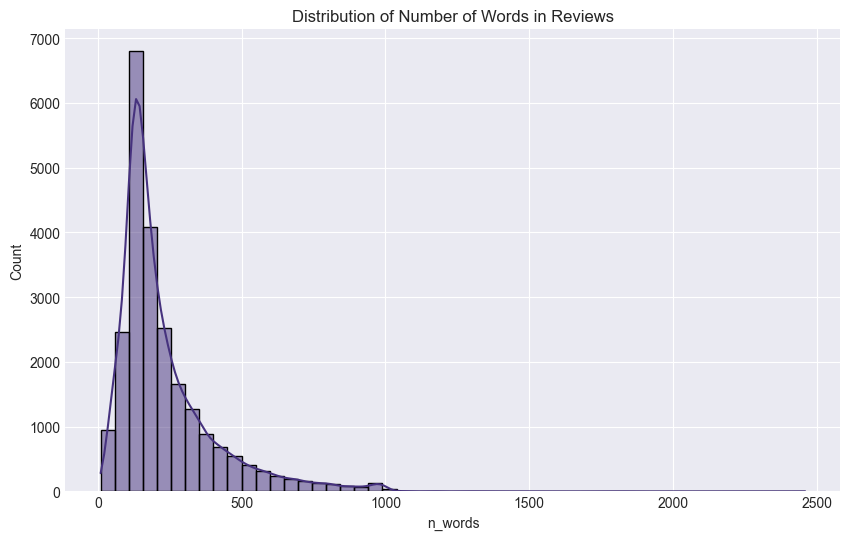

In [9]:
# Hist plot of n_words
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='n_words', bins=50, kde=True)
plt.title('Distribution of Number of Words in Reviews')
plt.show()

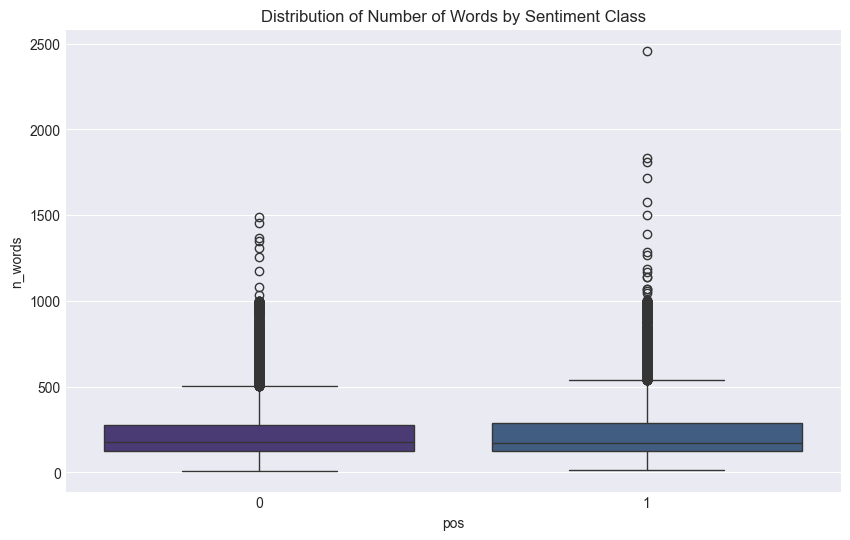

In [10]:
# Distribution of n_words by sentiment class
plt.figure(figsize=(10, 6))
sns.boxplot(x='pos', y='n_words', data=df_train, hue='pos', legend=False)
plt.title('Distribution of Number of Words by Sentiment Class')
plt.show()

In [11]:
# Check quartiles of n_words to decide max_length for tokenization
display(df_train['n_words'].quantile([0.5,0.9,0.95,0.99]))

0.50    174.00
0.90    455.00
0.95    594.00
0.99    906.44
Name: n_words, dtype: float64

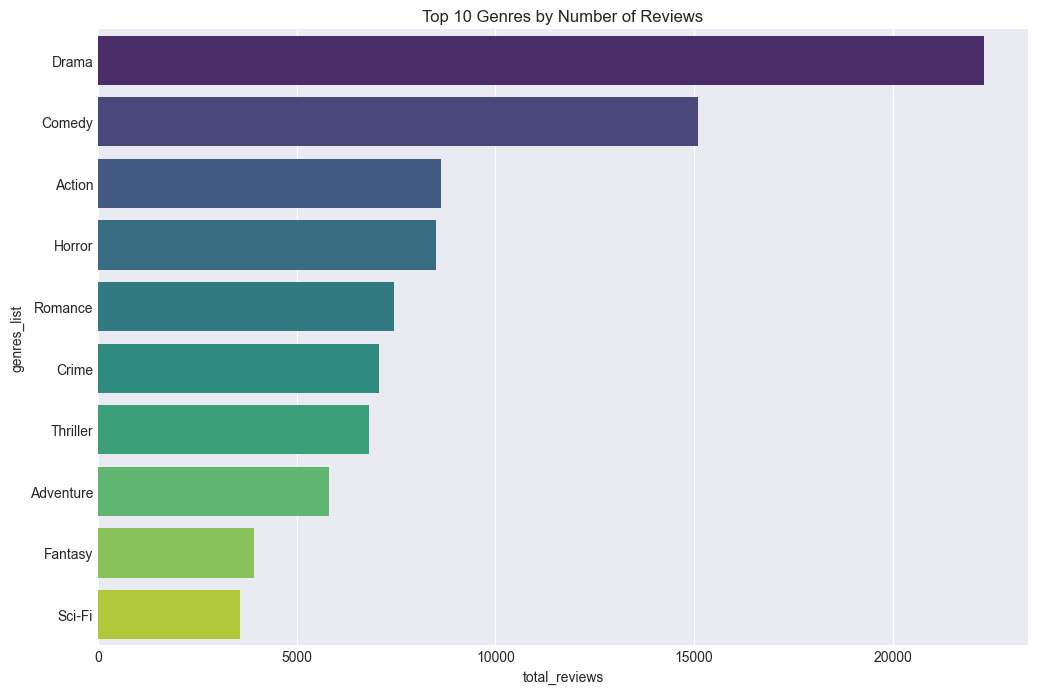

In [12]:
# Quick business EDA insight
data['genres_list'] = data['genres'].apply(lambda x: x.split(','))
data_exploded = data.explode('genres_list')
# Genres with the most reviews and their average sentiment
data_by_genre = data_exploded.groupby('genres_list').agg(
    total_reviews=('review', 'count'),
    average_sentiment=('pos', 'mean')
).sort_values(by='total_reviews', ascending=False).reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='total_reviews', y='genres_list', data=data_by_genre.head(10), palette='viridis', hue='genres_list', legend=False)
plt.title('Top 10 Genres by Number of Reviews')
plt.show()


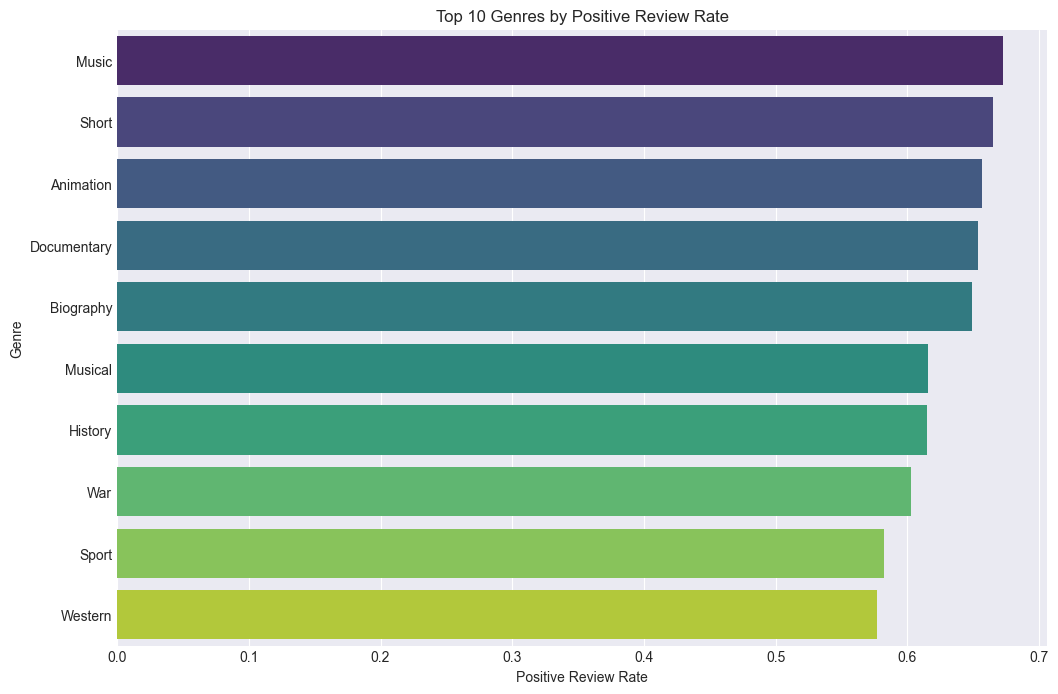

In [13]:
# Genres with the most positive rate sentiment
positive_genres = data_exploded.groupby('genres_list').agg(
    total_positive_reviews=('pos', 'sum'), total_reviews=('pos', 'count')).reset_index()
positive_genres['positive_rate'] = positive_genres['total_positive_reviews'] / positive_genres['total_reviews']
positive_genres = positive_genres[positive_genres['total_reviews'] > 500].sort_values(by='positive_rate', ascending=False).reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='positive_rate', y='genres_list', data=positive_genres.head(10), palette='viridis', hue='genres_list', legend=False)
plt.title('Top 10 Genres by Positive Review Rate')
plt.xlabel('Positive Review Rate')
plt.ylabel('Genre')
plt.show()

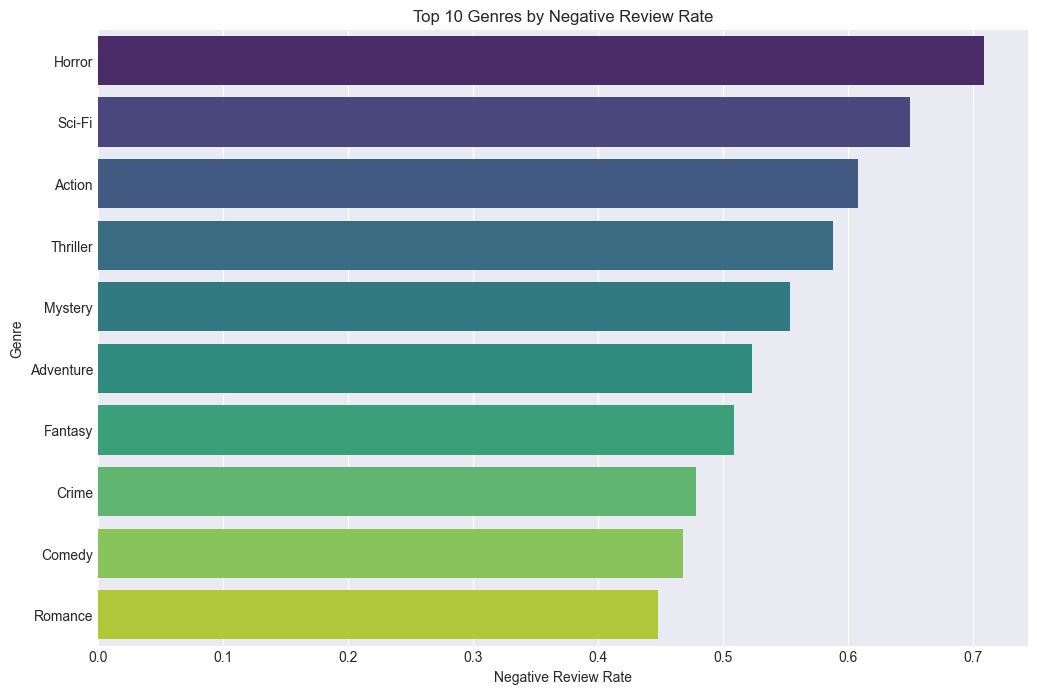

In [14]:
# Genres with the most negative rate sentiment
negative_genres = data_exploded.groupby('genres_list').agg(
    total_negative_reviews=('pos', lambda x: (x == 0).sum()),  total_reviews=('pos', 'count')).reset_index()
negative_genres['negative_rate'] = negative_genres['total_negative_reviews'] / negative_genres['total_reviews']
negative_genres = negative_genres[negative_genres['total_reviews'] > 500].sort_values(by='negative_rate', ascending=False).reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='negative_rate', y='genres_list', data=negative_genres.head(10), palette='viridis', hue='genres_list', legend=False)
plt.title('Top 10 Genres by Negative Review Rate')
plt.xlabel('Negative Review Rate')
plt.ylabel('Genre')
plt.show()

## **Observaciones del EDA**
* Observaciones importantes para el modelado:
    * Las clases están balanceadas en ambos conjuntos (train y test).
    * El texto de las reseñas es bastante limpio por lo que no se necesitará limpieza adicional.
    * La longitud de las reseñas varía mucho, pero la mayoría tiene menos de 500 palabras. Se decidió usar una longitud máxima de 256 tokens para BERT, por recursos computacionales y max_features = 50_000 con configuracion de ngram_range = (1, 2).
    * Las reseñas positivas tienden a ser ligeramente más largas que las negativas, pero la diferencia no es significativa.

* Resultados de las insights de negocio:
    
    * Drama, comedy y action son los géneros más comunes en las reseñas.
    * Los géneros con mayor proporción de reseñas negativas son horror y Sci-Fi, mientras que music y short tienen más ratio de reseñas positivas.

# **Ingeniería de características y modelado**
* Creación de conjuntos de entrenamiento, validación y prueba.
* Creación de funciones para preprocesar texto. 
* Creación de funciones para evaluar modelos y mostrar reportes de clasificación y matrices de confusión.
* Basado en el EDA, se decidió no eliminar stopwords ni hacer stemming/lemmatization y solamente normalizar espacios y pasar a minúsculas.
* Implementación de un modelo base simple usando `DummyClassifier` para establecer un punto de referencia.
* Creación de pipelines de modelado con TF-IDF + Regresión Logística y LinearSVC.
* Búsqueda de hiperparámetros con GridSearchCV.
* Creación de un pipeline completo para fine-tuning de BERT usando Hugging Face Transformers.
* Evaluación de modelos en el conjunto de validación y selección del mejor modelo basado en F1-score.


In [15]:
# Define X and y for train, validation, and test sets
X_ = df_train['review']
y_ = df_train['pos']
# Test set maintain untouchable until the end
X_test = df_test['review']
y_test = df_test['pos']

# Split train set into validation and train sets
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=RANDOM_SEED, stratify=y_ )

In [16]:
# Function to clean and preprocess text data
def clean_texts(texts : pd.Series) -> pd.Series:
    """Preprocess text data by lowercasing and normalizing spaces.
    
    Args:
        texts (pd.Series): Series of text data to preprocess.
    Returns:
        pd.Series: Preprocessed text data.    
        """
    texts = texts.str.lower()
    texts = texts.str.replace(r'\s+', ' ', regex=True).str.strip()
    return texts

In [17]:
# Function to evaluate model performance
def evaluate_model(model_name : str, y_true, y_pred, confusion_matrix: bool = False, verbose: bool = False) -> dict:
    '''
    Evaluate model performance and print classification report and confusion matrix.
    
    Args:
        model_name (str): Name of the model being evaluated.
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        confusion_matrix (bool): Whether to display confusion matrix. Default is False.
        verbose (bool): Whether to print detailed classification report. Default is False.
        
    Returns:
        dict: Dictionary containing the model name, F1 Score, precision and recall.
    '''
    result = {'model': model_name}
    
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    result.update({'f1_score': f1, 'precision': precision, 'recall': recall, 'accuracy': accuracy})
    
    if verbose:
        print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred, zero_division=0))
    
    if confusion_matrix:
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
        plt.title(f"Confusion Matrix for {model_name}")
        plt.show()
    
    return result

In [18]:
# Clean training, validation, and test texts
X_train = clean_texts(X_train)
X_val = clean_texts(X_val)
X_test = clean_texts(X_test)
# Lists to store results
val_results = []
test_results = []

Classification Report for Dummy Classifier:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67      2379
           1       0.00      0.00      0.00      2373

    accuracy                           0.50      4752
   macro avg       0.25      0.50      0.33      4752
weighted avg       0.25      0.50      0.33      4752



c:\Users\carlo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


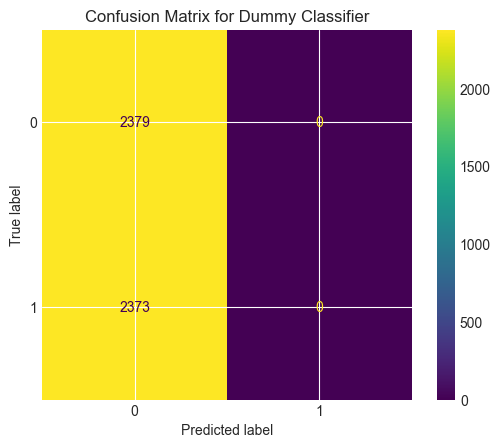

In [19]:
# Baseline Model: Dummy Classifier
# Create and train DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_val_pred_dummy = dummy_clf.predict(X_val)

# Validation set evaluation
dummy_val_results = evaluate_model("Dummy Classifier", y_val, y_val_pred_dummy, confusion_matrix=True, verbose=True)
val_results.append(dummy_val_results)

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      2379
           1       0.89      0.90      0.90      2373

    accuracy                           0.90      4752
   macro avg       0.90      0.90      0.90      4752
weighted avg       0.90      0.90      0.90      4752



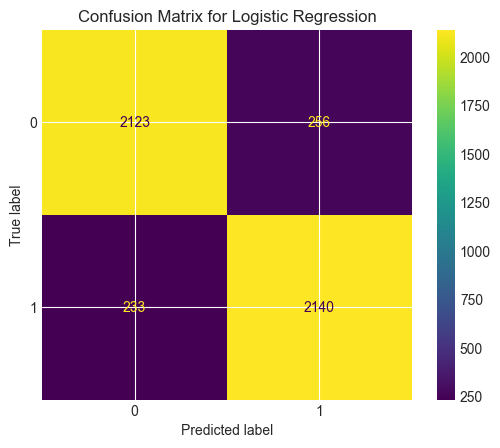

In [20]:
# Create TF-IDF + Logistic Regression pipeline
# Tfidf Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=50_000, ngram_range=(1,2), min_df=5, max_df=0.9)

# Pipeline
lr_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('lr', LogisticRegression(max_iter=1000))
])

# Train the pipeline
lr_pipeline.fit(X_train, y_train)
# Predict on validation set
y_val_pred_lr = lr_pipeline.predict(X_val)
# Evaluate Logistic Regression model
lr_val_results = evaluate_model("Logistic Regression", y_val, y_val_pred_lr, confusion_matrix=True, verbose=True)
val_results.append(lr_val_results)

In [21]:
# LinearSVC Pipeline
# Pipeline
svc_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('svc', LinearSVC(max_iter=1000))
])
# Param grid
svc_param_grid = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__max_df": [0.9, 0.95],
    "tfidf__min_df": [2, 5],
    "svc__C": [0.5, 1.0, 2.0]
}
# Cross-validation strategy
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Hyperparameters for LinearSVC: {'svc__C': 0.5, 'tfidf__max_df': 0.9, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Classification Report for LinearSVC:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90      2379
           1       0.90      0.91      0.90      2373

    accuracy                           0.90      4752
   macro avg       0.90      0.90      0.90      4752
weighted avg       0.90      0.90      0.90      4752



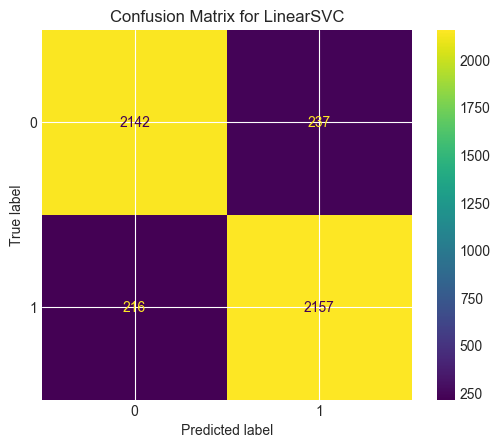

In [22]:
# Grid Search with Cross-Validation for SVC
svc_grid_search = GridSearchCV(
    svc_pipeline,
    param_grid=svc_param_grid,
    scoring='f1',
    cv=skf,
    n_jobs=-1,
    verbose=2
)
# Fit the grid search
svc_grid_search.fit(X_train, y_train)
# Best estimator from grid search
best_svc_model = svc_grid_search.best_estimator_
print("Best Hyperparameters for LinearSVC:", svc_grid_search.best_params_)
# Predict on validation set
y_val_pred_svc = best_svc_model.predict(X_val)
# Evaluate LinearSVC model
svc_val_results = evaluate_model("LinearSVC", y_val, y_val_pred_svc, confusion_matrix=True, verbose=True)
val_results.append(svc_val_results)

## **BERT Fine-tuning Pipeline**

In [23]:
# Dataset creation class for IMDb reviews
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
class ReviewDataset(Dataset):
    """Movie review dataset for BERT sentiment fine-tuning.

    Each item returns a dictionary with:
      - input_ids: token IDs (1D tensor)
      - attention_mask: attention mask (1D tensor)
      - labels: class label (scalar long tensor)
      - token_type_ids (optional): segment IDs for BERT-like models
    """

    reviews: List[str] | pd.Series | np.ndarray
    labels: List[int]| pd.Series | np.ndarray
    tokenizer: BertTokenizer
    max_len: int

    def __init__(
        self,
        reviews: List[str]| pd.Series | np.ndarray,
        labels: List[int]| pd.Series | np.ndarray,
        tokenizer: BertTokenizer,
        max_len: int,
    ) -> None:
        """Initialize the dataset.

        Args:
            reviews: List of raw review texts.
            labels: List of integer labels (e.g., 0/1).
            tokenizer: Hugging Face-compatible tokenizer.
            max_len: Maximum sequence length in tokens.
        """
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self) -> int:
        """Return total number of examples."""
        return len(self.reviews)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """Return tokenized example at index `idx`.

        Args:
            idx: Index of the example.

        Returns:
            Dictionary with BERT-ready tensors:
            - 'input_ids'
            - 'attention_mask'
            - 'labels'
            - 'token_type_ids' (if tokenizer provides them)
        """
        text = self.reviews.iloc[idx]
        label = int(self.labels.iloc[idx])

        encoder = tokenizer( 
            str(text.lower()),
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        item: Dict[str, torch.Tensor] = {
            'input_ids': encoder['input_ids'].squeeze(0),
            'attention_mask': encoder['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

        if "token_type_ids" in encoder:
            item["token_type_ids"] = encoder["token_type_ids"].squeeze(0)

        return item

In [24]:
# Model training function by epoch
def train_epoch(model : BertForSequenceClassification, data_loader: DataLoader, optimizer : AdamW, scheduler, device: torch.device | str = DEVICE) -> float:
    '''
    Trains the model for one epoch on the provided data loader.
    Args:
        model (BertForSequenceClassification): The BERT model for sequence classification.
        data_loader (DataLoader): DataLoader for the training data.
        optimizer (AdamW): Optimizer for model parameters.
        scheduler: Learning rate scheduler.
        device (torch.device | str): Device to run the model on (e.g., 'cuda' or 'cpu').
    Returns:
        float: Average loss over the epoch.
    '''
    model.train()
    total_loss = 0
    
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
    
    avg_loss = total_loss/len(data_loader)
    return avg_loss

In [25]:
# Evaluation function
def eval_model(model: BertForSequenceClassification, data_loader: DataLoader, device: torch.device | str = DEVICE) -> Tuple[Dict, float]:
    '''
    Evaluates the model on the provided data loader.
    Args:
        model (BertForSequenceClassification): The BERT model for sequence classification.
        data_loader (DataLoader): DataLoader for the evaluation data.
        device (torch.device | str): Device to run the model on (e.g., 'cuda' or 'cpu').
    Returns:
        Dict, float: A dictionary containing model name, F1 Score, precision and recall, and the average loss.
    '''
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            preds = torch.argmax(logits, dim=1).flatten()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    results = evaluate_model("BERT", all_labels, all_preds, confusion_matrix=True, verbose=True)
    
    return results, avg_loss

In [26]:
# Function to predict a text

def predict_text(text, model, tokenizer, max_len, device):
    model.eval()
    enc = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids      = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

    return preds.cpu().numpy()

In [27]:
# Create Datasets for all data splits we have
# Train Dataset
train_dataset = ReviewDataset(X_train, y_train, tokenizer, MAX_LEN)
# Validation Dataset
val_dataset = ReviewDataset(X_val, y_val, tokenizer, MAX_LEN)
# Test Dataset
test_dataset = ReviewDataset(X_test, y_test, tokenizer, MAX_LEN)

In [28]:
# Now we create the DataLoaders for every split
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

val_loader = DataLoader(val_dataset, shuffle=True, batch_size=BATCH_SIZE)

test_loader = DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [29]:
# Model creation, optimizer and scheduler initialization
BERTmodel = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
BERTmodel = BERTmodel.to(DEVICE)

optimizer = AdamW(BERTmodel.parameters(), lr=LR)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Train loss: 0.27422078377535875
Classification Report for BERT:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91      2379
           1       0.89      0.95      0.92      2373

    accuracy                           0.92      4752
   macro avg       0.92      0.92      0.92      4752
weighted avg       0.92      0.92      0.92      4752



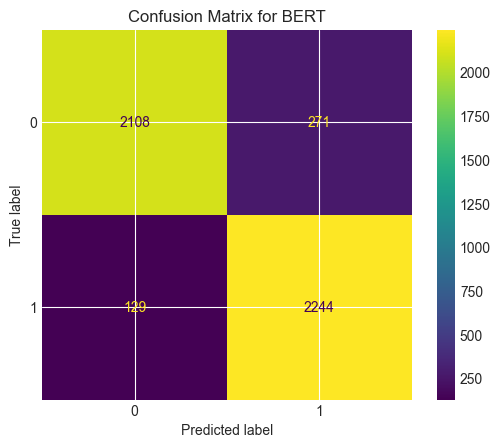

Validation loss: 0.2162
Best model updated.
Epoch 2/3
Train loss: 0.12305022977835026
Classification Report for BERT:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      2379
           1       0.92      0.92      0.92      2373

    accuracy                           0.92      4752
   macro avg       0.92      0.92      0.92      4752
weighted avg       0.92      0.92      0.92      4752



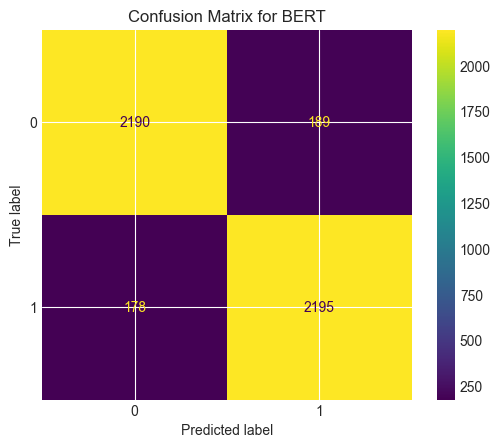

Validation loss: 0.2296
Best model updated.
Epoch 3/3
Train loss: 0.048688369979517476
Classification Report for BERT:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      2379
           1       0.92      0.92      0.92      2373

    accuracy                           0.92      4752
   macro avg       0.92      0.92      0.92      4752
weighted avg       0.92      0.92      0.92      4752



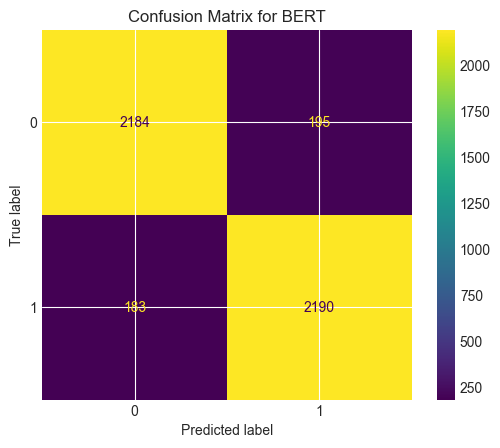

Validation loss: 0.2835
Best model updated.


In [30]:
# Training loop
for epoch in range(EPOCHS):
    best_F1 = 0.0
    best_model_state = None
    best_results = {}
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_loss = train_epoch(BERTmodel, train_loader, optimizer, scheduler, DEVICE)
    print(f'Train loss: {train_loss}')
    
    bert_val_results, val_loss = eval_model(BERTmodel, val_loader, DEVICE)
    print(f'Validation loss: {val_loss:.4f}')
    
    if bert_val_results['f1_score'] > best_F1:
        best_F1 = bert_val_results['f1_score']
        best_model_state = BERTmodel.state_dict().copy()
        best_results = bert_val_results
        print('Best model updated.')
        
        
if best_model_state is not None:
    BERTmodel.load_state_dict(best_model_state)

In [31]:
# Append best validation results for BERT
val_results.append(best_results)

In [32]:
# Create validation results DataFrame
val_results_df = pd.DataFrame(val_results).sort_values(by='f1_score', ascending=False).reset_index(drop=True)
display(val_results_df)

,model,f1_score,precision,recall,accuracy
0,BERT,0.920555,0.918239,0.922882,0.920455
1,LinearSVC,0.904972,0.901003,0.908976,0.904672
2,Logistic Regression,0.897463,0.893155,0.901812,0.897096
3,Dummy Classifier,0.000000,0.000000,0.000000,0.500631


# **Evaluación final en el conjunto de prueba**
* Evaluar el modelo base (DummyClassifier) en el conjunto de prueba para establecer un punto de referencia.
* Evaluar los tres modelos (TF-IDF + Regresión Logística, LinearSVC, BERT) en el conjunto de prueba.
* Comparar métricas (F1-score, accuracy, precision, recall) y analizar diferencias en el rendimiento.
* Realizar un live testing con reseñas escritas manualmente para evaluar la robustez de los modelos seleccionados.

Classification Report for Dummy Classifier:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67     11785
           1       0.00      0.00      0.00     11698

    accuracy                           0.50     23483
   macro avg       0.25      0.50      0.33     23483
weighted avg       0.25      0.50      0.34     23483



c:\Users\carlo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


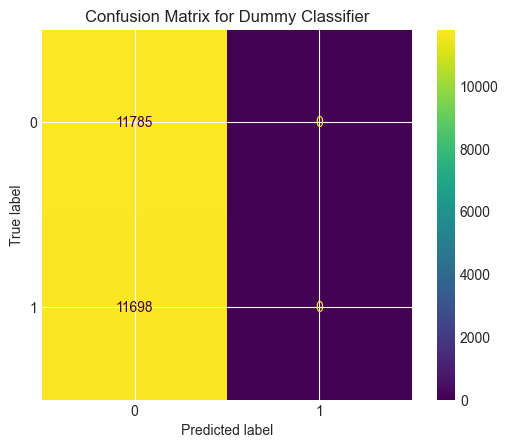

In [33]:
# DummyClassifier Test set evaluation
y_test_pred_dummy = dummy_clf.predict(X_test)
dummy_test_results = evaluate_model("Dummy Classifier", y_test, y_test_pred_dummy, confusion_matrix=True, verbose=True)
test_results.append(dummy_test_results)

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89     11785
           1       0.89      0.89      0.89     11698

    accuracy                           0.89     23483
   macro avg       0.89      0.89      0.89     23483
weighted avg       0.89      0.89      0.89     23483



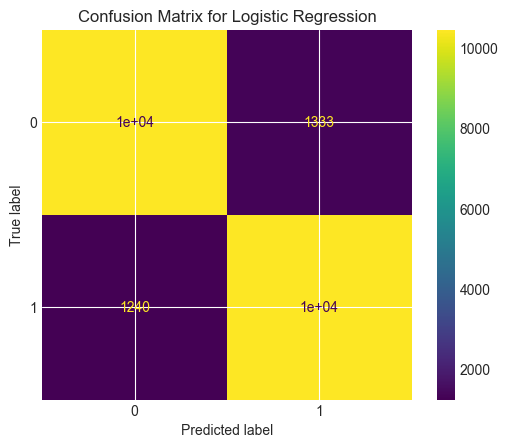

In [34]:
# Logistic Regression final evaluation on test set
y_test_pred_lr = lr_pipeline.predict(X_test)
lr_test_results = evaluate_model("Logistic Regression", y_test, y_test_pred_lr, confusion_matrix=True, verbose=True)
test_results.append(lr_test_results)

Classification Report for LinearSVC:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90     11785
           1       0.90      0.89      0.90     11698

    accuracy                           0.90     23483
   macro avg       0.90      0.90      0.90     23483
weighted avg       0.90      0.90      0.90     23483



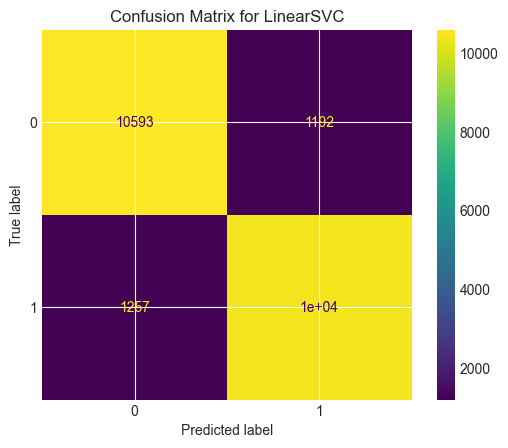

In [35]:
# LinearSVC final evaluation on test set
y_test_pred_svc = best_svc_model.predict(X_test)
svc_test_results = evaluate_model("LinearSVC", y_test, y_test_pred_svc, confusion_matrix=True, verbose=True)
test_results.append(svc_test_results)

Classification Report for BERT:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     11785
           1       0.92      0.93      0.92     11698

    accuracy                           0.92     23483
   macro avg       0.92      0.92      0.92     23483
weighted avg       0.92      0.92      0.92     23483



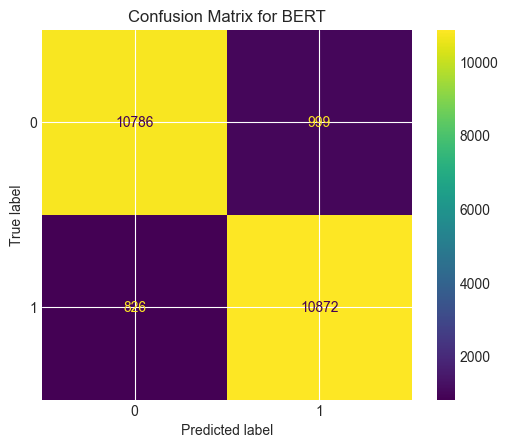

BERT Test loss: 0.2701


In [36]:
# BERT final evaluation on test set
bert_test_results, avg_loss = eval_model(BERTmodel, test_loader, DEVICE)
print(f'BERT Test loss: {avg_loss:.4f}')
test_results.append(bert_test_results)

In [37]:
# Create test results DataFrame
test_results_df = pd.DataFrame(test_results).sort_values(by='f1_score', ascending=False).reset_index(drop=True)
display(test_results_df)

,model,f1_score,precision,recall,accuracy
0,BERT,0.922568,0.915845,0.929390,0.922284
1,LinearSVC,0.895032,0.897533,0.892546,0.895712
2,Logistic Regression,0.890459,0.886948,0.893999,0.890431
3,Dummy Classifier,0.000000,0.000000,0.000000,0.501852


## Conclusión Ingeniería de características, modelado y testing

Para **ingeniería de características**, el enfoque **TF-IDF** resultó ser una representación fuerte y estable para este problema: tanto **Logistic Regression** como **LinearSVC** alcanzaron un desempeño alto y consistente, confirmando que los modelos lineales funcionan muy bien con texto vectorizado (sparse) en un escenario de sentimiento binario.

En **modelado**, se entrenaron y compararon tres enfoques serios y se compararon con un modelo base simple (DummyClassifier):

* **DummyClassifier (baseline simple)**: como se esperaba, tuvo un rendimiento muy bajo (**F1 test ≈ 0.00**), sirviendo como referencia mínima.
* **Logistic Regression (baseline)**: entregó un rendimiento competitivo (**F1 test ≈ 0.898**), sirviendo como referencia sólida por su simplicidad y velocidad.
* **LinearSVC**: mostró una mejora ligera frente al baseline (**F1 test ≈ 0.89**), manteniendo un buen balance precisión/recall y confirmando su fortaleza típica en texto con TF-IDF.
* **BERT (modelo profundo)**: obtuvo el mejor resultado global (**F1 test ≈ 0.92**), evidenciando la ventaja de modelos contextuales para capturar dependencias semánticas que TF-IDF no modela explícitamente.

En **testing**, las métricas en **validación y test** fueron muy cercanas para los tres modelos (especialmente en BERT), lo cual sugiere **buena generalización** y ausencia de señales fuertes de sobreajuste. Con base en el criterio principal (**F1-score**), **BERT fue el modelo final seleccionado**, ya que entrega la mayor mejora real en desempeño, mientras que **LinearSVC y Logistic Regression** quedan como alternativas eficientes cuando se prioriza rapidez y menor costo computacional.


# **Live testing con reseñas escritas manualmente**
Se probaran las reseñas escritas manualmente con los tres modelos entrenados:

In [38]:
# Manual review testing

manual_reviews = {
    "r01": {"review": "A wonderful film from start to finish. Great acting, tight pacing, and a satisfying ending.", "mood": "positive", "pos": 1},
    "r02": {"review": "Absolutely loved it. The dialogue is sharp, the direction is confident, and the soundtrack is beautiful.", "mood": "positive", "pos": 1},
    "r03": {"review": "This was terrible. Bad acting, boring story, and I regret watching it.", "mood": "negative", "pos": 0},
    "r04": {"review": "Awful movie. Nothing makes sense and it drags forever.", "mood": "negative", "pos": 0},

    "r05": {"review": "I didn't expect to like it, but it turned out to be genuinely moving and surprisingly funny.", "mood": "positive (negation flip)", "pos": 1},
    "r06": {"review": "I wanted to like it, but it just isn't good—flat characters and a messy plot.", "mood": "negative (contrast)", "pos": 0},
    "r07": {"review": "Not perfect, yet the performances are strong and the story stays with you.", "mood": "positive (mixed but favorable)", "pos": 1},
    "r08": {"review": "It has a few decent moments, but overall it's dull and painfully predictable.", "mood": "negative (mixed but unfavorable)", "pos": 0},

    "r09": {"review": "Wow, what a masterpiece—if you enjoy watching paint dry for two hours.", "mood": "negative (sarcasm)", "pos": 0},
    "r10": {"review": "Sure, it's 'deep'... in the way a puddle is deep after five minutes of rain.", "mood": "negative (irony)", "pos": 0},
    "r11": {"review": "I guess it was 'just okay'—except I smiled the entire time and immediately wanted to rewatch it.", "mood": "positive (sarcastic phrasing)", "pos": 1},
    "r12": {"review": "The best part was the credits, because it meant the movie was finally over.", "mood": "negative (sarcasm)", "pos": 0},

    "r13": {"review": "The visuals are stunning, but the story feels hollow and the characters never clicked for me.", "mood": "negative (praise + complaint)", "pos": 0},
    "r14": {"review": "Some scenes are excellent, others are a mess. I can see why people like it, but it didn't work for me.", "mood": "negative (mixed leaning negative)", "pos": 0},
    "r15": {"review": "Quiet, restrained, and honestly pretty brave. It doesn’t shout, it just lands.", "mood": "positive (subtle)", "pos": 1},
    "r16": {"review": "Technically competent, but emotionally empty. I felt nothing and forgot it immediately.", "mood": "negative (subtle)", "pos": 0},
}
# Dataframe creation
manual_reviews_df = pd.DataFrame.from_dict(manual_reviews, orient='index')
manual_reviews_df


,review,mood,pos
r01,A wonderful film from start to finish. Great a...,positive,1
r02,"Absolutely loved it. The dialogue is sharp, th...",positive,1
r03,"This was terrible. Bad acting, boring story, a...",negative,0
r04,Awful movie. Nothing makes sense and it drags ...,negative,0
r05,"I didn't expect to like it, but it turned out ...",positive (negation flip),1
r06,"I wanted to like it, but it just isn't good—fl...",negative (contrast),0
r07,"Not perfect, yet the performances are strong a...",positive (mixed but favorable),1
r08,"It has a few decent moments, but overall it's ...",negative (mixed but unfavorable),0
r09,"Wow, what a masterpiece—if you enjoy watching ...",negative (sarcasm),0
r10,"Sure, it's 'deep'... in the way a puddle is de...",negative (irony),0


In [39]:
# Preprocess manual reviews
manual_reviews_df['review'] = clean_texts(manual_reviews_df['review'])
manual_reviews_df.head()
live_test_results = []

In [40]:
# Predict sample reviews with the Logistic Regression model
manual_reviews_df['lr_pred'] = lr_pipeline.predict(manual_reviews_df['review'])
live_test_lr = evaluate_model("Logistic Regression - Manual Reviews", manual_reviews_df['pos'], manual_reviews_df['lr_pred'], verbose=True)
display(manual_reviews_df[['review','pos', 'lr_pred', 'mood']])
live_test_results.append(live_test_lr)

Classification Report for Logistic Regression - Manual Reviews:
               precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.57      0.67      0.62         6

    accuracy                           0.69        16
   macro avg       0.67      0.68      0.68        16
weighted avg       0.70      0.69      0.69        16



,review,pos,lr_pred,mood
r01,a wonderful film from start to finish. great a...,1,1,positive
r02,"absolutely loved it. the dialogue is sharp, th...",1,1,positive
r03,"this was terrible. bad acting, boring story, a...",0,0,negative
r04,awful movie. nothing makes sense and it drags ...,0,0,negative
r05,"i didn't expect to like it, but it turned out ...",1,1,positive (negation flip)
r06,"i wanted to like it, but it just isn't good—fl...",0,0,negative (contrast)
r07,"not perfect, yet the performances are strong a...",1,1,positive (mixed but favorable)
r08,"it has a few decent moments, but overall it's ...",0,0,negative (mixed but unfavorable)
r09,"wow, what a masterpiece—if you enjoy watching ...",0,0,negative (sarcasm)
r10,"sure, it's 'deep'... in the way a puddle is de...",0,0,negative (irony)


In [41]:
# Predict sample reviews with LinearSVC model
manual_reviews_df['svc_pred'] = best_svc_model.predict(manual_reviews_df['review'])
live_test_svc = evaluate_model("LinearSVC - Manual Reviews", manual_reviews_df['pos'], manual_reviews_df['svc_pred'], verbose=True)
display(manual_reviews_df[['review','pos', 'svc_pred', 'mood']])
live_test_results.append(live_test_svc)

Classification Report for LinearSVC - Manual Reviews:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.67      0.67      0.67         6

    accuracy                           0.75        16
   macro avg       0.73      0.73      0.73        16
weighted avg       0.75      0.75      0.75        16



,review,pos,svc_pred,mood
r01,a wonderful film from start to finish. great a...,1,1,positive
r02,"absolutely loved it. the dialogue is sharp, th...",1,1,positive
r03,"this was terrible. bad acting, boring story, a...",0,0,negative
r04,awful movie. nothing makes sense and it drags ...,0,0,negative
r05,"i didn't expect to like it, but it turned out ...",1,1,positive (negation flip)
r06,"i wanted to like it, but it just isn't good—fl...",0,0,negative (contrast)
r07,"not perfect, yet the performances are strong a...",1,1,positive (mixed but favorable)
r08,"it has a few decent moments, but overall it's ...",0,0,negative (mixed but unfavorable)
r09,"wow, what a masterpiece—if you enjoy watching ...",0,0,negative (sarcasm)
r10,"sure, it's 'deep'... in the way a puddle is de...",0,0,negative (irony)


In [42]:
# Predict sample reviews with the best model (BERT)
manual_reviews_df['bert_pred'] = manual_reviews_df['review'].apply(lambda x: predict_text(x, BERTmodel, tokenizer, MAX_LEN, DEVICE)[0])
live_test_bert = evaluate_model("BERT - Manual Reviews", manual_reviews_df['pos'], manual_reviews_df['bert_pred'], verbose=True)
display(manual_reviews_df[['review','pos', 'bert_pred', 'mood']])
live_test_results.append(live_test_bert)

Classification Report for BERT - Manual Reviews:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.75      1.00      0.86         6

    accuracy                           0.88        16
   macro avg       0.88      0.90      0.87        16
weighted avg       0.91      0.88      0.88        16



,review,pos,bert_pred,mood
r01,a wonderful film from start to finish. great a...,1,1,positive
r02,"absolutely loved it. the dialogue is sharp, th...",1,1,positive
r03,"this was terrible. bad acting, boring story, a...",0,0,negative
r04,awful movie. nothing makes sense and it drags ...,0,0,negative
r05,"i didn't expect to like it, but it turned out ...",1,1,positive (negation flip)
r06,"i wanted to like it, but it just isn't good—fl...",0,0,negative (contrast)
r07,"not perfect, yet the performances are strong a...",1,1,positive (mixed but favorable)
r08,"it has a few decent moments, but overall it's ...",0,0,negative (mixed but unfavorable)
r09,"wow, what a masterpiece—if you enjoy watching ...",0,1,negative (sarcasm)
r10,"sure, it's 'deep'... in the way a puddle is de...",0,0,negative (irony)


In [43]:
# Live test results DataFrame
live_test_results_df = pd.DataFrame(live_test_results).sort_values(by='f1_score', ascending=False).reset_index(drop=True)
display(live_test_results_df)

,model,f1_score,precision,recall,accuracy
0,BERT - Manual Reviews,0.857143,0.750000,1.000000,0.8750
1,LinearSVC - Manual Reviews,0.666667,0.666667,0.666667,0.7500
2,Logistic Regression - Manual Reviews,0.615385,0.571429,0.666667,0.6875


## **Observaciones del live testing**
* Los tres modelos manejaron bien las reseñas claramente positivas y negativas, con BERT mostrando la mayor precisión.
* Las reseñas con sentimientos más sutiles o matizados fueron desafiantes para todos los modelos, pero BERT aún logró capturar mejor estas sutilezas.
* El sarcasmo y las reseñas con lenguaje ambiguo fueron los casos más difíciles, con errores notables en todos los modelos, aunque BERT tuvo menos fallos en comparación con los modelos basados en TF-IDF.
* Esta evaluación manual es una demostración cualitativa que complementa las métricas cuantitativas, mostrando la robustez de los modelos en escenarios del mundo real.

# **Conclusión final del proyecto**

En este proyecto se construyó un **clasificador de sentimiento (positivo/negativo)** a partir de reseñas de texto, siguiendo un flujo completo de ciencia de datos: **preprocesamiento**, **ingeniería de características**, **entrenamiento**, **validación**, **selección de modelo** y **evaluación final**.

Se entrenaron y compararon **tres enfoques**:

* **Logistic Regression + TF-IDF**, como baseline lineal fuerte para texto.
* **LinearSVC + TF-IDF**, otro modelo lineal competitivo, con buen desempeño y estabilidad.
* **BERT (fine-tuning)**, un modelo contextual moderno que aprende significado más allá de palabras sueltas.

Los resultados mostraron un patrón consistente en **validación y test**:
**BERT fue el mejor modelo**, alcanzando aproximadamente **F1 ≈ 0.92**, superando a **LinearSVC (~0.89)** y **Logistic Regression (~0.89)**. Esto confirma que el contexto y la semántica (BERT) aportan valor frente a representaciones tipo bolsa de palabras (TF-IDF), especialmente cuando hay matices en el lenguaje.

Adicionalmente, se realizó un **live test con reseñas escritas a mano** para evaluar robustez en casos más “humanos” (sarcasmo, ironía, negación, opiniones mixtas). Aunque las métricas bajaron por el tamaño pequeño (solo 16 ejemplos) y por la dificultad, **BERT se mantuvo como el mejor**, y los errores se concentraron principalmente en **sarcasmo/ironía y reseñas mixtas**, que son casos conocidos como complicados para modelos supervisados estándar.

En conclusión: el sistema final recomendado para producción/prototipo es **BERT**, por su mejor desempeño general y mejor comprensión contextual, mientras que **LinearSVC/LogReg** quedan como alternativas más rápidas y ligeras si se prioriza velocidad/recursos por encima del rendimiento máximo.
